### Reminder (Before we start)
Check whether the kernel at the top right is set to "urbs" in order to be able to run this script.

# Example 1: Electricity supply of an island

## Learning objectives
* Translate a mathematical optimization problem into a pyomo ConcreteModel/AbstractModel
* Recognize the basic structure of an optimization model
* Report the results of pyomo in different formats
* Run and edit scripts using pyomo, pandas and matplotlib

## Mathematical formulation

We start with a simple example. Let's assume we have a gas power plant ($P_{gas}$ = 100 MW) and a biomass power plant ($P_{bm}$ = 30 MW) supplying an island. The cost of supplying 1 MWh of electricity using the gas power plant is EUR 50, whereas the cost of using biomass is 25 EUR/MWh. These costs include operation and maintenance costs and fuel costs. The efficiency of the power plants is already taken into account.

We would like to minimize the cost of operating the system for a given demand of electricity $d(t)$.

$$\min \quad 50s_{gas}(t) + 25s_{bm}(t)$$
$$s.t. \quad s_{gas}(t) + s_{bm}(t) \geq d(t)$$

The supply from the power plant is non-negative:
$$s_{gas}(t), s_{bm}(t) \geq 0$$

It cannot exceed the capacity of the power plants:
$$s_{gas}(t) \leq 100$$
$$s_{bm}(t) \leq 30$$

Further, we define the demand as follows:
$$d(t) = [60, 100, 120, 80, 30]$$

***
### <span style="color:blue">Task</span>
Try to solve this problem with pen and paper!
***

## Formulation as a pyomo ConcreteModel

We could solve this problem using a pyomo ConcreteModel:

In [20]:
# Load the object "environ" from the library "pyomo" which is already installed in our urbs environment.
# Whenever we will use it, we will call it using its alias "pyo"
import pyomo.environ as pyo

# Let's create a ConcreteModel object and fill it with life!
model = pyo.ConcreteModel()
model.name = "Example1"

## Variables
# Our variable "s" (supply) has two dimensions: time and technology. It is always positive.
model.s = pyo.Var(["t1", "t2", "t3", "t4", "t5"], ["Gas", "Biomass"], domain=pyo.NonNegativeReals)

## Objective function
# The objective is also a variable, albeit a special one which we will optimize.
model.OBJ = pyo.Objective(expr=50*model.s["t1", "Gas"] + 25*model.s["t1", "Biomass"] +\
                               50*model.s["t2", "Gas"] + 25*model.s["t2", "Biomass"] +\
                               50*model.s["t3", "Gas"] + 25*model.s["t3", "Biomass"] +\
                               50*model.s["t4", "Gas"] + 25*model.s["t4", "Biomass"] +\
                               50*model.s["t5", "Gas"] + 25*model.s["t5", "Biomass"], sense=pyo.maximize)

## Constraints
# The supply from the Gas power plant cannot exceed its capacity of 100 MW
model.ConstraintGasCap1 = pyo.Constraint(expr = model.s["t1", "Gas"] <= 100)
model.ConstraintGasCap2 = pyo.Constraint(expr = model.s["t2", "Gas"] <= 100)
model.ConstraintGasCap3 = pyo.Constraint(expr = model.s["t3", "Gas"] <= 100)
model.ConstraintGasCap4 = pyo.Constraint(expr = model.s["t4", "Gas"] <= 100)
model.ConstraintGasCap5 = pyo.Constraint(expr = model.s["t5", "Gas"] <= 100)

# The supply from the Biomass power plant cannot exceed its capacity of 30 MW
model.ConstraintBiomassCap1 = pyo.Constraint(expr = model.s["t1", "Biomass"] <= 30)
model.ConstraintBiomassCap2 = pyo.Constraint(expr = model.s["t2", "Biomass"] <= 30)
model.ConstraintBiomassCap3 = pyo.Constraint(expr = model.s["t3", "Biomass"] <= 30)
model.ConstraintBiomassCap4 = pyo.Constraint(expr = model.s["t4", "Biomass"] <= 30)
model.ConstraintBiomassCap5 = pyo.Constraint(expr = model.s["t5", "Biomass"] <= 30)

# The supply should at least be equal to the demand
model.ConstraintDem1 = pyo.Constraint(expr = model.s["t1", "Gas"] + model.s["t1", "Biomass"] == 60)
model.ConstraintDem2 = pyo.Constraint(expr = model.s["t2", "Gas"] + model.s["t2", "Biomass"] == 100)
model.ConstraintDem3 = pyo.Constraint(expr = model.s["t3", "Gas"] + model.s["t3", "Biomass"] == 120)
model.ConstraintDem4 = pyo.Constraint(expr = model.s["t4", "Gas"] + model.s["t4", "Biomass"] == 80)
model.ConstraintDem5 = pyo.Constraint(expr = model.s["t5", "Gas"] + model.s["t5", "Biomass"] == 30)

In [21]:
# Write the LP mathematical problem that is solved to a file (optional)
# Here, we are reporting the model itself, not its solution
model.write("01_concrete_a.lp")

('01_concrete_a.lp', 2116858302080)

***
### <span style="color:blue">Task</span>
Open the file "01_concrete_a.lp" with a text editor. Can you recognize the variables and constraints?
***

In [22]:
# Try this now
model.write("01_concrete_b.lp", io_options={'symbolic_solver_labels': True})

('01_concrete_b.lp', 2116858300568)

Now let's solve the model!

In [23]:
# We first load the solver
opt = pyo.SolverFactory('glpk') # glpk: GNU Linear Programming Kit
results = opt.solve(model)
# First way of reporting the solution
results

{'Problem': [{'Name': 'unknown', 'Lower bound': 19000.0, 'Upper bound': 19000.0, 'Number of objectives': 1, 'Number of constraints': 16, 'Number of variables': 11, 'Number of nonzeros': 21, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.012973785400390625}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [24]:
print(results.Solver)


- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.012973785400390625



> For more on solver status and termination conditions:
http://www.pyomo.org/blog/2015/1/8/accessing-solver

In [25]:
model.display()

Model Example1

  Variables:
    s : Size=10, Index=s_index
        Key               : Lower : Value : Upper : Fixed : Stale : Domain
        ('t1', 'Biomass') :     0 :   0.0 :  None : False : False : NonNegativeReals
            ('t1', 'Gas') :     0 :  60.0 :  None : False : False : NonNegativeReals
        ('t2', 'Biomass') :     0 :   0.0 :  None : False : False : NonNegativeReals
            ('t2', 'Gas') :     0 : 100.0 :  None : False : False : NonNegativeReals
        ('t3', 'Biomass') :     0 :  20.0 :  None : False : False : NonNegativeReals
            ('t3', 'Gas') :     0 : 100.0 :  None : False : False : NonNegativeReals
        ('t4', 'Biomass') :     0 :   0.0 :  None : False : False : NonNegativeReals
            ('t4', 'Gas') :     0 :  80.0 :  None : False : False : NonNegativeReals
        ('t5', 'Biomass') :     0 :   0.0 :  None : False : False : NonNegativeReals
            ('t5', 'Gas') :     0 :  30.0 :  None : False : False : NonNegativeReals

  Objectives:


***
### <span style="color:blue">Task</span>
1. Try to comment one or multiple constraints. What happens?
2. Try to maximize instead of minimizing the costs. (Tip: add the option 'sense=pyo.maximize' into the objective function)
3. How easy is it to add another power plant? Another time step?
***

## Formulation as a pyomo AbstractModel

One way to add flexibility is to write the problem abstractly. For example, the following equations represent a linear program (LP) to find optimal values for the vector $x$ (in our case, the hourly supply from the power plants) with parameters $c_j$ (costs), $a_{i,j}$ and $b_i$ (constraints):

$$ \begin{array}{lll} \min & \sum_{j=1}^n c_j x_{j,t} & \\
s.t. & \sum_{j=1}^n a_{i,j} x_{j,t} \geq b_{i,t} & \forall i = 1 \ldots m\\ & x_{j,t} \geq 0 & \forall j = 1 \ldots n
\end{array} $$ 

For that, there is the pyomo class AbstractModel:

In [26]:
# Here we are loading all the objects within "pyomo.environ" and we can use them directly.
# The script will recognize their names. This is practical, but not a good coding style.
# There could be issues if you use one of the "reserved names" that are already defined in the library.
from pyomo.environ import *

model = AbstractModel()

# Sets
model.I = Set() # we could define the dimensions, or let pyomo determine them from the data
model.J = Set()
model.T = Set()

# Parameters
model.a = Param(model.I, model.J)
model.b = Param(model.I, model.T)
model.c = Param(model.J)

# Variables
model.x = Var(model.J, model.T, domain=NonNegativeReals) # the variable is indexed by the set J and the set T

# Objective function
def obj_expression(model):
    sigma = 0
    for t in model.T:
        for j in model.J:
            sigma = sigma + model.c[j] * model.x[(j, t)]
    return sigma

model.OBJ = Objective(rule=obj_expression)

# Constraints
def ax_constraint_rule(model, i, t):
    # return the expression for the constraint for i
    return sum(model.a[i,j] * model.x[j, t] for j in model.J) >= model.b[i, t]

model.AxbConstraint = Constraint(model.I, model.T, rule=ax_constraint_rule) # this creates one constraint for each member of the set model.I

model.dual = Suffix(direction=Suffix.IMPORT)

***
### <span style="color:blue">Task</span>
With pen and paper, determine the parameters a, b, and c to replicate the concrete model.
***

By running the code, we create an abstract model. Now we need to create an instance of it:

In [27]:
# We can create an instance without filling it with data
instance = model.create_instance()
instance.pprint()

7 Set Declarations
    AxbConstraint_index : Dim=0, Dimen=2, Size=0, Domain=None, Ordered=False, Bounds=None
        Virtual
    I : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=False, Bounds=None
        []
    J : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=False, Bounds=None
        []
    T : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=False, Bounds=None
        []
    a_index : Dim=0, Dimen=2, Size=0, Domain=None, Ordered=False, Bounds=None
        Virtual
    b_index : Dim=0, Dimen=2, Size=0, Domain=None, Ordered=False, Bounds=None
        Virtual
    x_index : Dim=0, Dimen=2, Size=0, Domain=None, Ordered=False, Bounds=None
        Virtual

3 Param Declarations
    a : Size=0, Index=a_index, Domain=Any, Default=None, Mutable=False
        Key : Value
    b : Size=0, Index=b_index, Domain=Any, Default=None, Mutable=False
        Key : Value
    c : Size=0, Index=J, Domain=Any, Default=None, Mutable=False
        Key : Value

1 Var Declarations
    x : Size=0, Index=x_index
     

In [28]:
# We can load data from a file (written in AMPL format)
data = DataPortal()
data.load(filename='01_abstract.dat')
# You can view the defined sets and parameters here
list(data.keys())

['I', 'J', 'T', 'c', 'a', 'b']

***
### <span style="color:blue">Task</span>
Compare your results for the parameters a, b, and c with the used values in _01_abstract.dat_.
***

In [29]:
# We can create an instance that is filled with input data
instance = model.create_instance(data)
instance.pprint()

7 Set Declarations
    AxbConstraint_index : Dim=0, Dimen=2, Size=15, Domain=None, Ordered=False, Bounds=None
        Virtual
    I : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=False, Bounds=None
        ['BiomassCap', 'Dem', 'GasCap']
    J : Dim=0, Dimen=1, Size=2, Domain=None, Ordered=False, Bounds=None
        ['Biomass', 'Gas']
    T : Dim=0, Dimen=1, Size=5, Domain=None, Ordered=False, Bounds=None
        ['t1', 't2', 't3', 't4', 't5']
    a_index : Dim=0, Dimen=2, Size=6, Domain=None, Ordered=False, Bounds=None
        Virtual
    b_index : Dim=0, Dimen=2, Size=15, Domain=None, Ordered=False, Bounds=None
        Virtual
    x_index : Dim=0, Dimen=2, Size=10, Domain=None, Ordered=False, Bounds=None
        Virtual

3 Param Declarations
    a : Size=6, Index=a_index, Domain=Any, Default=None, Mutable=False
        Key                       : Value
        ('BiomassCap', 'Biomass') :    -1
            ('BiomassCap', 'Gas') :     0
               ('Dem', 'Biomass') :     1
       

In [30]:
opt = SolverFactory('glpk')
status = opt.solve(instance)
status

{'Problem': [{'Name': 'unknown', 'Lower bound': 15750.0, 'Upper bound': 15750.0, 'Number of objectives': 1, 'Number of constraints': 16, 'Number of variables': 11, 'Number of nonzeros': 21, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.01414036750793457}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [31]:
instance.display()

Model unknown

  Variables:
    x : Size=10, Index=x_index
        Key               : Lower : Value : Upper : Fixed : Stale : Domain
        ('Biomass', 't1') :     0 :  30.0 :  None : False : False : NonNegativeReals
        ('Biomass', 't2') :     0 :  30.0 :  None : False : False : NonNegativeReals
        ('Biomass', 't3') :     0 :  30.0 :  None : False : False : NonNegativeReals
        ('Biomass', 't4') :     0 :  30.0 :  None : False : False : NonNegativeReals
        ('Biomass', 't5') :     0 :  30.0 :  None : False : False : NonNegativeReals
            ('Gas', 't1') :     0 :  30.0 :  None : False : False : NonNegativeReals
            ('Gas', 't2') :     0 :  70.0 :  None : False : False : NonNegativeReals
            ('Gas', 't3') :     0 :  90.0 :  None : False : False : NonNegativeReals
            ('Gas', 't4') :     0 :  50.0 :  None : False : False : NonNegativeReals
            ('Gas', 't5') :     0 :   0.0 :  None : False : False : NonNegativeReals

  Objectives:
 

In [32]:
# Another way of reporting the results
instance.solutions.store_to(status)
status.write(filename='01_abstract_results.json', format='json')

In [33]:
print ("Duals")
for c in instance.component_objects(Constraint, active=True):
    print ("   Constraint",c)
    for index in c:
        try:
            print ("      ", index, instance.dual[c[index]])
        except: # if there is an error, skip that constraint
            continue

Duals
   Constraint AxbConstraint
       ('GasCap', 't1') 0.0
       ('GasCap', 't2') 0.0
       ('GasCap', 't3') 0.0
       ('GasCap', 't4') 0.0
       ('GasCap', 't5') 0.0
       ('BiomassCap', 't1') 25.0
       ('BiomassCap', 't2') 25.0
       ('BiomassCap', 't3') 25.0
       ('BiomassCap', 't4') 25.0
       ('BiomassCap', 't5') 25.0
       ('Dem', 't1') 50.0
       ('Dem', 't2') 50.0
       ('Dem', 't3') 50.0
       ('Dem', 't4') 50.0
       ('Dem', 't5') 50.0


***
### <span style="color:blue">Task</span>
1. Set the demand in the last time step to 140. What happens?
2. How easy is it to add another power plant? Another time step?
***

## Reporting into pandas DataFrame objects

pandas is a package that allows you to organize your data in multidimensional "tables", so-called DataFrame objects. It is useful if you want to export your results into csv or Microsoft Excel format.

In [34]:
# load the library first
import pandas as pd

# we will create a dictionary from the model instance variable x
# the keys of the dictionary are the indices, the values are the x values
supply_data = {(j, t): value(x) for (j, t), x in instance.x.items()}

# create a DataFrame object from that dictionary
df_supply = pd.DataFrame.from_dict(supply_data, orient="index", columns=["SE [MWh]"])
df_supply

SE [MWh]
(Gas, t1)          30.0
(Gas, t2)          70.0
(Gas, t3)          90.0
(Gas, t4)          50.0
(Gas, t5)           0.0
(Biomass, t1)      30.0
(Biomass, t2)      30.0
(Biomass, t3)      30.0
(Biomass, t4)      30.0
(Biomass, t5)      30.0

In [35]:
# Let's make the index look better - through a multiindex
df_supply.index = pd.MultiIndex.from_tuples(df_supply.index, names=('Technology', 't'))
# Get rid of the letter t in the timesteps
df_supply.index = df_supply.index.set_levels(df_supply.index.levels[1].str.replace('t', ''), level=1)
# Show the DataFrame
df_supply

SE [MWh]
Technology t          
Gas        1      30.0
           2      70.0
           3      90.0
           4      50.0
           5       0.0
Biomass    1      30.0
           2      30.0
           3      30.0
           4      30.0
           5      30.0

In [36]:
# This looks already good... but let's try to pivot the table, so that technologies appear as columns
df_supply = df_supply.unstack(level=0)
df_supply

SE [MWh]      
Technology  Biomass   Gas
t                        
1              30.0  30.0
2              30.0  70.0
3              30.0  90.0
4              30.0  50.0
5              30.0   0.0

In [37]:
# The columns have two levels now, let's get rid of the first one
df_supply = df_supply.droplevel(0, axis=1)
df_supply

Technology  Biomass   Gas
t                        
1              30.0  30.0
2              30.0  70.0
3              30.0  90.0
4              30.0  50.0
5              30.0   0.0

In [38]:
# Let's add the unit to the names of the technologies
df_supply.columns = [x + " SE [MWh]" for x in df_supply.columns]
df_supply

Biomass SE [MWh]  Gas SE [MWh]
t                                
1              30.0          30.0
2              30.0          70.0
3              30.0          90.0
4              30.0          50.0
5              30.0           0.0

In [39]:
# We repeat this for the demand
# Since I know that the first character of the timesteps is always t, I index from 1 in t[1:] to get rid of it
demand_data = {t[1:]: value(x) for (i, t), x in instance.b.items() if i == "Dem"}

# create a DataFrame object from that dictionary
df_demand = pd.DataFrame.from_dict(demand_data, orient="index", columns=["D [MWh]"])
df_demand

D [MWh]
1       60
2      100
3      120
4       80
5       30

In [40]:
# Let' save the supply and demand into two different csv files
# ! Adapt the decimal character and the column separator to your local settings !
df_supply.to_csv("01_supply.csv", sep=";", decimal=",")
df_demand.to_csv("01_demand.csv", sep=";", decimal=",")

## Plotting with matplotlib

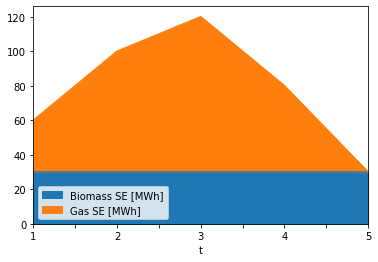

In [41]:
# Most basic plot
# pandas has in-built functions from matplotlib, so we can plot a DataFrame object
%matplotlib inline
df_supply.plot.area()

In [49]:
# import the library
import matplotlib.pyplot as plt

# Create an empty figure
fig = plt.figure()

# Now let's make an interactive object that we can edit with a GUI
%matplotlib
plot_supply = df_supply.plot.area(color=["darkgreen", "gray"], title = "Example 1")
# Add these options:
# To change the colors: color=["darkgreen", "gray"]
# To add title: title = "Example 1"

Using matplotlib backend: Qt5Agg


In [50]:
# Let's add the demand to the same plot
df_demand.plot.line(ax=plot_supply, color="k", linewidth=2)

***
## <span style="color:red">Homework</span>
1. Expand the timesteps to cover one day in summer and one day in winter (total: 48h)
2. Add a third technology, PV, with zero running costs and with varying upper bounds for every time step.
3. Plot your results: <br>
    a. separately for the summer day and the winter day (demand and supply curves, chronologically)<br>
    b. together for the sorted load duration curve<br>
    c. costs for each time step (same order as for the sorted load curve)
***